In [41]:
from pyspark import SparkConf
from pyspark import SparkContext

In [42]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AnimeRecommendationSystem") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [43]:
sc = spark.sparkContext

In [44]:
from IPython.display import Image
from IPython.display import display

In [45]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS 
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import socket, psutil, platform
from pyspark.mllib.recommendation import Rating
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
from pyspark.ml.tuning import CrossValidator

In [47]:
from pyspark.sql.functions import udf, col, when
from pyspark.ml import Pipeline
from pyspark.sql import Row

In [48]:
def get_system_info():
    hostname = socket.gethostname()
    
    ip_address = socket.gethostbyname(hostname)
    
    system = platform.system()
    node = platform.node()
    release = platform.release()
    version = platform.version()
    machine = platform.machine()
    processor = platform.processor()

    memory = psutil.virtual_memory()
    total_memory = memory.total
    available_memory = memory.available
    

    cpu_count = psutil.cpu_count(logical=True)
    
    print(f"Hostname: {hostname}")
    print(f"IP Address: {ip_address}")
    print(f"System: {system}")
    print(f"Node: {node}")
    print(f"Release: {release}")
    print(f"Version: {version}")
    print(f"Machine: {machine}")
    print(f"Processor: {processor}")
    print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
    print(f"CPU Count: {cpu_count}")

get_system_info()

Hostname: LAPTOP-H3SEJLE9
IP Address: 172.20.10.5
System: Windows
Node: LAPTOP-H3SEJLE9
Release: 10
Version: 10.0.22621
Machine: AMD64
Processor: AMD64 Family 23 Model 24 Stepping 1, AuthenticAMD
Total Memory: 14.94 GB
Available Memory: 8.17 GB
CPU Count: 8


In [49]:
anime_data_rdd = sc.textFile("animeText.txt")

In [50]:
rating_data_rdd = sc.textFile("ratingText.txt")

In [51]:
anime_data_rdd.first()

'anime_id\tname\tgenre\ttype\tepisodes\trating\tmembers'

In [52]:
rating_data_rdd.first()

'user_id\tanime_id\trating'

In [53]:
num_animes = anime_data_rdd.count()
print("Number of Animes: ", num_animes)

Number of Animes:  12295


In [54]:
anime_fields = anime_data_rdd.map(lambda lines: lines.split("\t"))

In [55]:
anime_fields.first()

['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']

In [56]:
rating_fields = rating_data_rdd.map(lambda lines: lines.split("\t") )

In [57]:
rating_fields.first()

['user_id', 'anime_id', 'rating']

In [58]:
anime_data = spark.read.csv("anime.csv", header=True, inferSchema=True)
rating_data = spark.read.csv("rating.csv", header=True, inferSchema=True)

In [59]:
anime_data.printSchema()

root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)



In [60]:
anime_data = anime_data.withColumnRenamed("rating", "general_rating")

In [61]:
rating_data.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [62]:
anime_data.take(3)

[Row(anime_id=32281, name='Kimi no Na wa.', genre='Drama, Romance, School, Supernatural', type='Movie', episodes='1', general_rating=9.37, members=200630),
 Row(anime_id=5114, name='Fullmetal Alchemist: Brotherhood', genre='Action, Adventure, Drama, Fantasy, Magic, Military, Shounen', type='TV', episodes='64', general_rating=9.26, members=793665),
 Row(anime_id=28977, name='Gintama°', genre='Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen', type='TV', episodes='51', general_rating=9.25, members=114262)]

In [63]:
raw_anime = anime_data_rdd.map(lambda line : line.split('\t'))
raw_anime.take(2)

[['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'],
 ['32281',
  'Kimi no Na wa.',
  'Drama, Romance, School, Supernatural',
  'Movie',
  '1',
  '9.37',
  '200630']]

In [84]:
raw_anime_header = raw_anime.first()
anime_fields = raw_anime.filter(lambda line: line != raw_anime_header)
anime_fields.take(5)

[['32281',
  'Kimi no Na wa.',
  'Drama, Romance, School, Supernatural',
  'Movie',
  '1',
  '9.37',
  '200630'],
 ['5114',
  'Fullmetal Alchemist: Brotherhood',
  'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
  'TV',
  '64',
  '9.26',
  '793665'],
 ['28977',
  'Gintama°',
  'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
  'TV',
  '51',
  '9.25',
  '114262'],
 ['9253', 'Steins;Gate', 'Sci-Fi, Thriller', 'TV', '24', '9.17', '673572'],
 ['9969',
  'Gintama&#039;',
  'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
  'TV',
  '51',
  '9.16',
  '151266']]

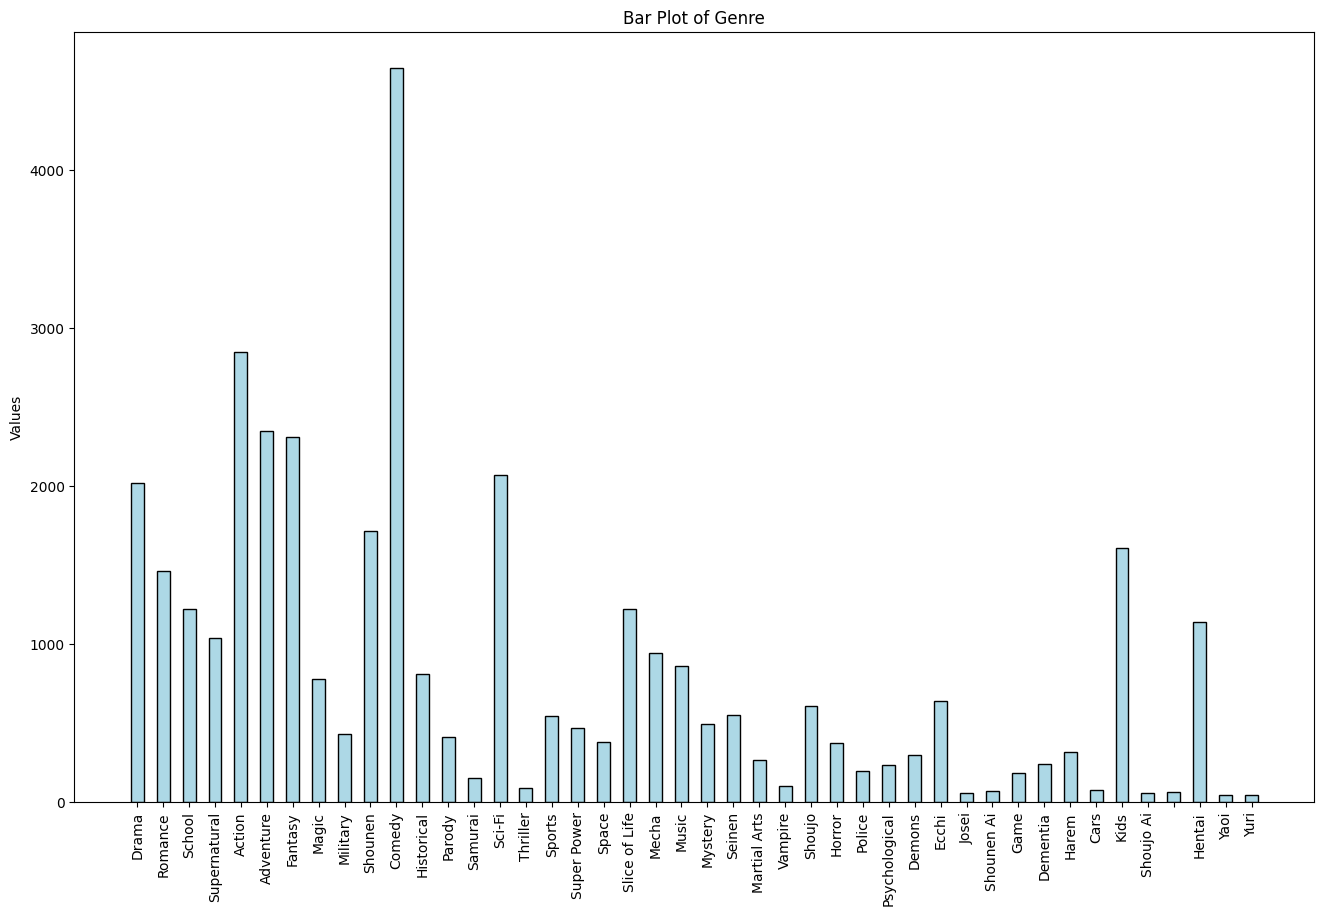

In [65]:
genres_fields = anime_fields.flatMap(lambda x: x[2].split(', '))

genre_counts = genres_fields.countByValue()

x_axis = np.array(list(genre_counts.keys()))
y_axis = np.array(list(genre_counts.values()))

pos = np.arange(len(x_axis))
width = 0.5

fig, ax = plt.subplots()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis, rotation=90)

plt.bar(pos, y_axis, width, color='lightblue', edgecolor='black', align='center')
fig.set_size_inches(16, 10)

plt.title("Bar Plot of Genre")
plt.ylabel("Values")

plt.show()

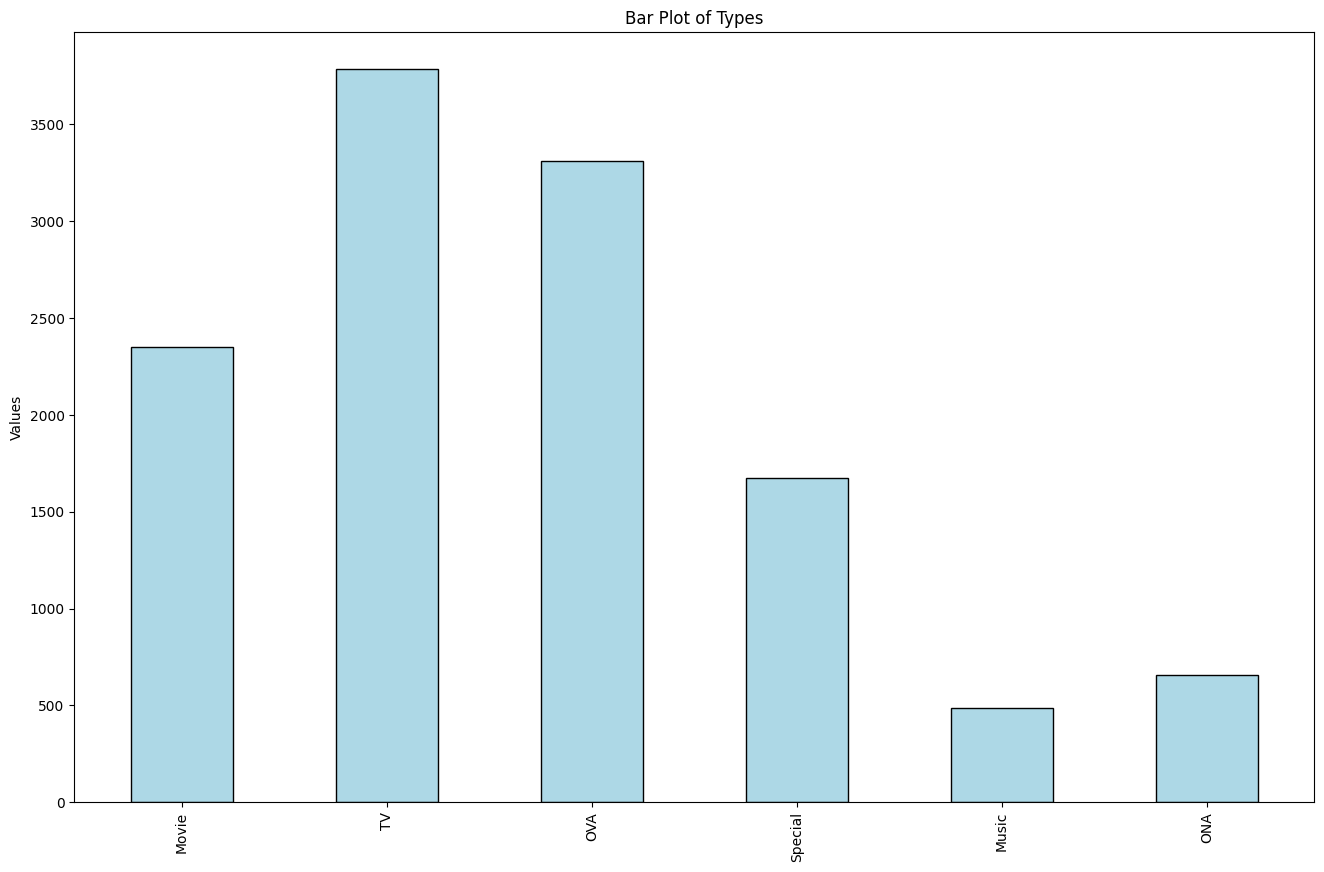

In [66]:
# type_fields oluşturulması
type_fields = anime_fields.flatMap(lambda x: x[3].split(', '))

# Her türün frekansını hesaplama
type_counts = type_fields.countByValue()

# 0 değeri olanları filtreleme
filtered_type_counts = {k: v for k, v in type_counts.items() if v > 50}

# Anahtarları ve değerleri NumPy dizilerine dönüştürme
x_axis = np.array(list(filtered_type_counts.keys()))
y_axis = np.array(list(filtered_type_counts.values()))

# Barların pozisyonlarını ve genişliğini tanımlama
pos = np.arange(len(x_axis))
width = 0.5

# Grafiği oluşturma
fig, ax = plt.subplots()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis, rotation=90)

# Bar grafiğini çizme
plt.bar(pos, y_axis, width, color='lightblue', edgecolor='black', align='center')
fig.set_size_inches(16, 10)

plt.title("Bar Plot of Types")
plt.ylabel("Values")

# Grafiği gösterme
plt.show()

In [67]:
raw_ratings = rating_data_rdd.map(lambda line : line.split('\t'))
raw_ratings.take(4)

[['user_id', 'anime_id', 'rating'],
 ['1', '20', '-1'],
 ['1', '24', '-1'],
 ['1', '79', '-1']]

In [68]:
raw_data_header = raw_ratings.first()
rating_fields = raw_ratings.filter(lambda line: line != raw_data_header and all(field != "" for field in line) and float(line[2]) != -1)
rating_fields.take(10)

[['1', '8074', '10'],
 ['1', '11617', '10'],
 ['1', '11757', '10'],
 ['1', '15451', '10'],
 ['2', '11771', '10'],
 ['3', '20', '8'],
 ['3', '154', '6'],
 ['3', '170', '9'],
 ['3', '199', '10'],
 ['3', '225', '9']]

In [69]:
ratings = rating_fields.map(lambda x: int(x[2]))
ratings.take(5)

[10, 10, 10, 10, 10]

In [70]:
ratings.stats()

(count: 6337241, mean: 7.8084969468576, stdev: 1.5724959064295263, max: 10.0, min: 1.0)

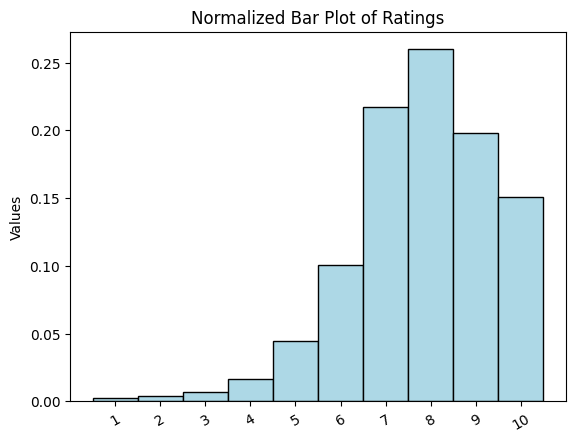

In [71]:
count_by_rating = ratings.countByValue()

sorted_ratings = sorted(count_by_rating.items())

x_axis = np.array([item[0] for item in sorted_ratings])
y_axis = np.array([float(item[1]) for item in sorted_ratings])

y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(len(x_axis))
width = 1.0

fig, ax = plt.subplots()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue', edgecolor='black', align='center')
plt.xticks(pos, x_axis, rotation=30)


plt.title("Normalized Bar Plot of Ratings")
plt.ylabel("Values")

plt.show()

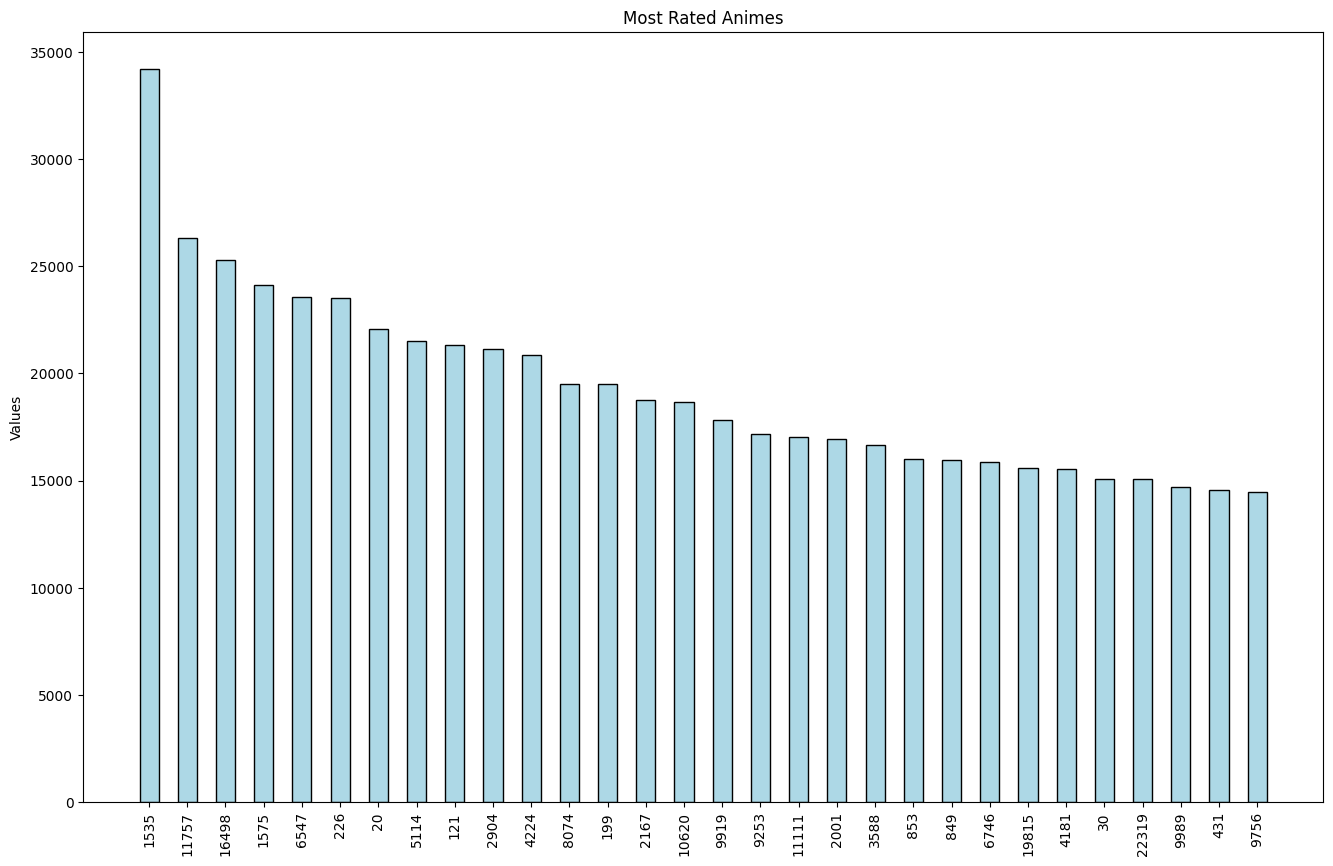

In [72]:
animeRating_fields = rating_fields.map(lambda x: x[1])
anime_counts = animeRating_fields.countByValue()

# 0 değeri olanları filtrelemeye gerek yok çünkü countByValue zaten sadece mevcut olanları sayar

# En çok oylanan 30 animeyi seç
top_30_anime = sorted(anime_counts.items(), key=lambda x: x[1], reverse=True)[:30]

# Anahtarları ve değerleri NumPy dizilerine dönüştürme
x_axis = np.array([x[0] for x in top_30_anime])
y_axis = np.array([x[1] for x in top_30_anime])

# Barların pozisyonlarını ve genişliğini tanımlama
pos = np.arange(len(x_axis))
width = 0.5

# Grafiği oluşturma
fig, ax = plt.subplots()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis, rotation=90)

# Bar grafiğini çizme
plt.bar(pos, y_axis, width, color='lightblue', edgecolor='black', align='center')
fig.set_size_inches(16, 10)

plt.title("Most Rated Animes")
plt.ylabel("Values")

# Grafiği gösterme
plt.show()

In [73]:
# • Build recommendation engine using collaborative filtering.

In [76]:
training_df , test_df = rate_df.randomSplit([0.7, 0.3], seed=5010)

In [75]:
from pyspark.sql.functions import col

rate_df = rating_data.withColumn("user_id", col("user_id").cast("integer")) \
       .withColumn("anime_id", col("anime_id").cast("integer")) \
       .withColumn("rating", col("rating").cast("float"))

rate_df.printSchema()
rate_df.show()

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: float (nullable = true)

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      1|      20|  -1.0|
|      1|      24|  -1.0|
|      1|      79|  -1.0|
|      1|     226|  -1.0|
|      1|     241|  -1.0|
|      1|     355|  -1.0|
|      1|     356|  -1.0|
|      1|     442|  -1.0|
|      1|     487|  -1.0|
|      1|     846|  -1.0|
|      1|     936|  -1.0|
|      1|    1546|  -1.0|
|      1|    1692|  -1.0|
|      1|    1836|  -1.0|
|      1|    2001|  -1.0|
|      1|    2025|  -1.0|
|      1|    2144|  -1.0|
|      1|    2787|  -1.0|
|      1|    2993|  -1.0|
|      1|    3455|  -1.0|
+-------+--------+------+
only showing top 20 rows



In [77]:
rate_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: float (nullable = true)



In [78]:
data = rating_fields

In [79]:
data.count()

6337241

In [80]:
ratings = data.map(lambda x: Row(user_id=int(x[0]), anime_id=int(x[1]), rating=float(x[2]))).toDF()

# Split data into training and test sets
trainingRatings, testRatings = ratings.randomSplit([0.7,0.3],seed=5010)

In [81]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Assuming Spark session is already created as spark
# spark = SparkSession.builder.appName("ALSExample").getOrCreate()

# Define the ALS model
als = ALS(userCol='user_id', itemCol='anime_id', ratingCol='rating',
          coldStartStrategy='drop', nonnegative=True)

# Parameter grid
ranks = [10, 15, 20]
maxIters = [10,15,20]
regParams = [0.01, 0.1]

# Evaluator for MSE and RMSE
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
evaluator_mse = RegressionEvaluator(metricName='mse', labelCol='rating', predictionCol='prediction')

# Best model and best metrics initialization
best_model = None
best_rmse = float('inf')
best_mse = float('inf')
best_rank = None
best_maxIter = None
best_regParam = None

# Loop over all combinations of hyperparameters
for rank in ranks:
    for maxIter in maxIters:
        for regParam in regParams:
            # Configure ALS with current hyperparameters
            als.setParams(rank=rank, maxIter=maxIter, regParam=regParam)
            
            # Fit the model
            model = als.fit(trainingRatings)
            
            # Generate predictions
            predictions = model.transform(testRatings)  # Assuming you have a validation set
            
            # Evaluate the model
            rmse = evaluator_rmse.evaluate(predictions)
            mse = evaluator_mse.evaluate(predictions)
            
            # Print the metrics
            print(f'Rank: {rank}, MaxIter: {maxIter}, RegParam: {regParam}')
            print(f'RMSE: {rmse}, MSE: {mse}')
            
            # Update best model if current model is better
            if rmse < best_rmse:
                best_model = model
                best_rmse = rmse
                best_mse = mse
                best_rank = rank
                best_maxIter = maxIter
                best_regParam = regParam

# Print best model hyperparameters and metrics
print('Best Model:')
print('Rank:', best_rank)
print('MaxIter:', best_maxIter)
print('RegParam:', best_regParam)
print('Best RMSE:', best_rmse)
print('Best MSE:', best_mse)


Rank: 10, MaxIter: 10, RegParam: 0.01
RMSE: 1.180815350817234, MSE: 1.3943248927256275
Rank: 10, MaxIter: 10, RegParam: 0.1
RMSE: 1.1731780027274898, MSE: 1.3763466260836625
Rank: 10, MaxIter: 15, RegParam: 0.01
RMSE: 1.1794113102176378, MSE: 1.3910110386692858
Rank: 10, MaxIter: 15, RegParam: 0.1
RMSE: 1.1535760682452774, MSE: 1.3307377452282327
Rank: 10, MaxIter: 20, RegParam: 0.01
RMSE: 1.1776868490403651, MSE: 1.3869463144026235
Rank: 10, MaxIter: 20, RegParam: 0.1
RMSE: 1.1444896423246689, MSE: 1.3098565413884484
Rank: 15, MaxIter: 10, RegParam: 0.01
RMSE: 1.2037615627284417, MSE: 1.44904189990242
Rank: 15, MaxIter: 10, RegParam: 0.1
RMSE: 1.1727257703225304, MSE: 1.3752857323785725
Rank: 15, MaxIter: 15, RegParam: 0.01
RMSE: 1.2045787796232477, MSE: 1.4510100363186325
Rank: 15, MaxIter: 15, RegParam: 0.1
RMSE: 1.1503463327008172, MSE: 1.3232966851582189
Rank: 15, MaxIter: 20, RegParam: 0.01
RMSE: 1.2026316526499974, MSE: 1.446322891955664
Rank: 15, MaxIter: 20, RegParam: 0.1
RMSE

In [ ]:
#predictions = best_model.transform(test_df)

In [82]:
predictions.show(n=10)

+--------+------+-------+----------+
|anime_id|rating|user_id|prediction|
+--------+------+-------+----------+
|     148|   8.0|  56435|  7.186411|
|     148|   7.0|  57661| 6.7427278|
|     148|   6.0|   5214|  6.216945|
|     148|   4.0|  51555| 6.4887934|
|     148|   7.0|  28932|   6.71248|
|     148|   6.0|  51013| 6.5154896|
|     148|   8.0|   6384|  6.142517|
|     148|   9.0|  26338|  8.406232|
|     148|   6.0|  59186|  7.610029|
|     148|   6.0|  10826|  6.954573|
+--------+------+-------+----------+
only showing top 10 rows



In [83]:
predictions.join(anime_data, "anime_id").select("user_id","name", "genre", "type", "episodes","general_rating", "rating", "members","prediction").show(10)

+-------+--------------------+--------------------+----+--------+--------------+------+-------+----------+
|user_id|                name|               genre|type|episodes|general_rating|rating|members|prediction|
+-------+--------------------+--------------------+----+--------+--------------+------+-------+----------+
|  56435|Kita e.: Diamond ...|Drama, Romance, S...|  TV|      12|          6.77|   8.0|   5736|  7.186411|
|  57661|Kita e.: Diamond ...|Drama, Romance, S...|  TV|      12|          6.77|   7.0|   5736| 6.7427278|
|   5214|Kita e.: Diamond ...|Drama, Romance, S...|  TV|      12|          6.77|   6.0|   5736|  6.216945|
|  51555|Kita e.: Diamond ...|Drama, Romance, S...|  TV|      12|          6.77|   4.0|   5736| 6.4887934|
|  28932|Kita e.: Diamond ...|Drama, Romance, S...|  TV|      12|          6.77|   7.0|   5736|   6.71248|
|  51013|Kita e.: Diamond ...|Drama, Romance, S...|  TV|      12|          6.77|   6.0|   5736| 6.5154896|
|   6384|Kita e.: Diamond ...|Drama, 

In [85]:
# Prediction for 1 specific user only. user_id=1989 olan kullanıcı için prediction.

for_one_user = predictions.filter(col("user_id")==1989).join(anime_data, "anime_id").select("user_id","name", "prediction")
for_one_user.count()

13

In [88]:
#user_id numarası 1989 olan kullanıcı için 3 prediction.

for_one_user.show(3)

+-------+--------------------+----------+
|user_id|                name|prediction|
+-------+--------------------+----------+
|   1989|         Log Horizon|  8.878421|
|   1989|Mahouka Koukou no...|  8.584672|
|   1989|         Date A Live|  8.128227|
+-------+--------------------+----------+
only showing top 3 rows



In [89]:
# Generate top 10 animes recommendation for each user
userRecomments = best_model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each anime
animeRecomments = best_model.recommendForAllItems(10)

In [90]:
userRecomments.select("user_id","recommendations.anime_id").show(10, False)

+-------+-------------------------------------------------------------------+
|user_id|anime_id                                                           |
+-------+-------------------------------------------------------------------+
|148    |[4331, 7416, 820, 338, 28977, 32422, 11061, 30743, 9376, 9969]     |
|463    |[7416, 30743, 32422, 8353, 4640, 6733, 28851, 5114, 28977, 9969]   |
|471    |[30743, 9558, 33281, 7416, 17985, 22615, 22477, 22479, 5235, 708]  |
|496    |[30743, 4640, 8353, 32422, 22059, 22477, 22479, 22615, 11061, 5114]|
|833    |[30743, 8353, 32422, 6383, 820, 7416, 5895, 4640, 9253, 5114]      |
|1088   |[8353, 30743, 7416, 20969, 7877, 6560, 10620, 16762, 8745, 2688]   |
|1238   |[30743, 8353, 28851, 32422, 6383, 4640, 4181, 2904, 9253, 5114]    |
|1342   |[6383, 17985, 22049, 22059, 30743, 30234, 6702, 6890, 1604, 5235]  |
|1580   |[7416, 8353, 30743, 32422, 7877, 9495, 28851, 6202, 4181, 32281]   |
|1591   |[22607, 4640, 9376, 13755, 5197, 820, 17137, 4509, 6735

In [92]:
titles = anime_fields.map(lambda line: line[:2]).map(lambda x: (int(x[0]),x[1])).collectAsMap()

In [93]:
recommendations_data = []

for row in userRecomments.limit(10).collect():
    user_id = row['user_id']
    recommendations = row['recommendations']
    anime_ids = [anime['anime_id'] for anime in recommendations]
    anime_names = [titles[anime_id] for anime_id in anime_ids]
    recommendations_data.append((user_id, anime_names))

recommendations_df = pd.DataFrame(recommendations_data, columns=['User ID', 'Recommendations'])
# DataFrame'i bastır
print(recommendations_df)

   User ID                                    Recommendations
0      148  [Penguin no Mondai, Socket, Ginga Eiyuu Denset...
1      463  [Socket, Kanagatari. Kanabakari.: Kanadian Fam...
2      471  [Kanagatari. Kanabakari.: Kanadian Families, C...
3      496  [Kanagatari. Kanabakari.: Kanadian Families, M...
4      833  [Kanagatari. Kanabakari.: Kanadian Families, K...
5     1088  [Ketsuinu, Kanagatari. Kanabakari.: Kanadian F...
6     1238  [Kanagatari. Kanabakari.: Kanadian Families, K...
7     1342  [Chargeman Ken!, Kero Kero Keroppi no Boku-tac...
8     1580  [Socket, Ketsuinu, Kanagatari. Kanabakari.: Ka...
9     1591  [Ahiru no Pekkle no Suieitaikai wa Oosawagi, M...


In [94]:
titles[4331]

'Penguin no Mondai'

In [91]:
animeRecomments.select("anime_id", "recommendations.user_id").show(10, False)

+--------+----------------------------------------------------------------------+
|anime_id|user_id                                                               |
+--------+----------------------------------------------------------------------+
|1580    |[32061, 17075, 6737, 6634, 61132, 13876, 50963, 6441, 49775, 29586]   |
|5300    |[53199, 71640, 24452, 56206, 6980, 42754, 64807, 15569, 7179, 50902]  |
|9900    |[52638, 60634, 61110, 54492, 10925, 45539, 59847, 29560, 31540, 8350] |
|471     |[60634, 59847, 55636, 28304, 66554, 52638, 29560, 66623, 53709, 60261]|
|1591    |[52764, 50297, 6501, 52168, 16827, 15618, 55636, 52638, 6980, 60634]  |
|4101    |[60634, 52638, 61110, 29560, 59847, 45539, 8350, 53709, 25160, 51976] |
|11141   |[6308, 6304, 17744, 68943, 56964, 22830, 48088, 53641, 49758, 57628]  |
|24171   |[20707, 47492, 44160, 57805, 72794, 54134, 37765, 3566, 8931, 36372]  |
|25591   |[49775, 57668, 27792, 70193, 36009, 16125, 23687, 46697, 18673, 3269] |
|1342    |[17605

In [95]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType

In [96]:
item_id = 28085 
item_vector = best_model.itemFactors.filter(col("id") == item_id).select("features").collect()[0][0]

user_vectors = best_model.userFactors.select("features").rdd.map(lambda x: x[0]).collect()

def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_product = float(v1.norm(2) * v2.norm(2))
    if norm_product == 0:
        return 0  
    similarity = dot_product / norm_product
    return round(similarity, 4) 

cosine_similarities = [(i, cosine_similarity(Vectors.dense(item_vector), Vectors.dense(user_vector))) for i, user_vector in enumerate(user_vectors)]

top_10_users = sorted(cosine_similarities, key=lambda x: -x[1])[:10]

print("Top 10 Users who will like Anime", item_id)
for user_index, similarity in top_10_users:
    print("User:", user_index, "| Cosine Similarity:", similarity)


Top 10 Users who will like Anime 28085
User: 38202 | Cosine Similarity: 0.9788
User: 10385 | Cosine Similarity: 0.9766
User: 57890 | Cosine Similarity: 0.9705
User: 53467 | Cosine Similarity: 0.97
User: 25287 | Cosine Similarity: 0.9698
User: 59480 | Cosine Similarity: 0.9694
User: 59609 | Cosine Similarity: 0.9676
User: 11553 | Cosine Similarity: 0.9665
User: 1241 | Cosine Similarity: 0.9661
User: 33528 | Cosine Similarity: 0.9658


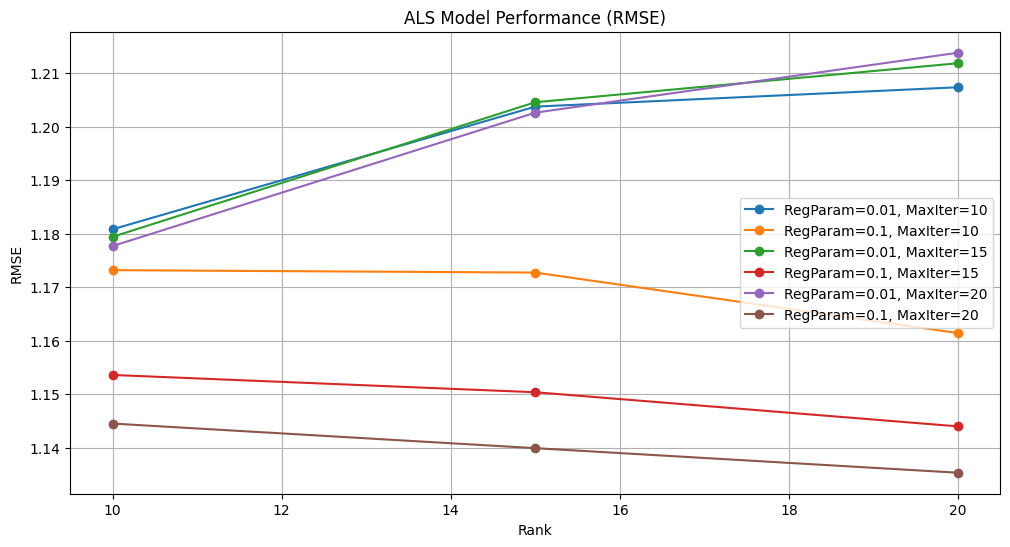

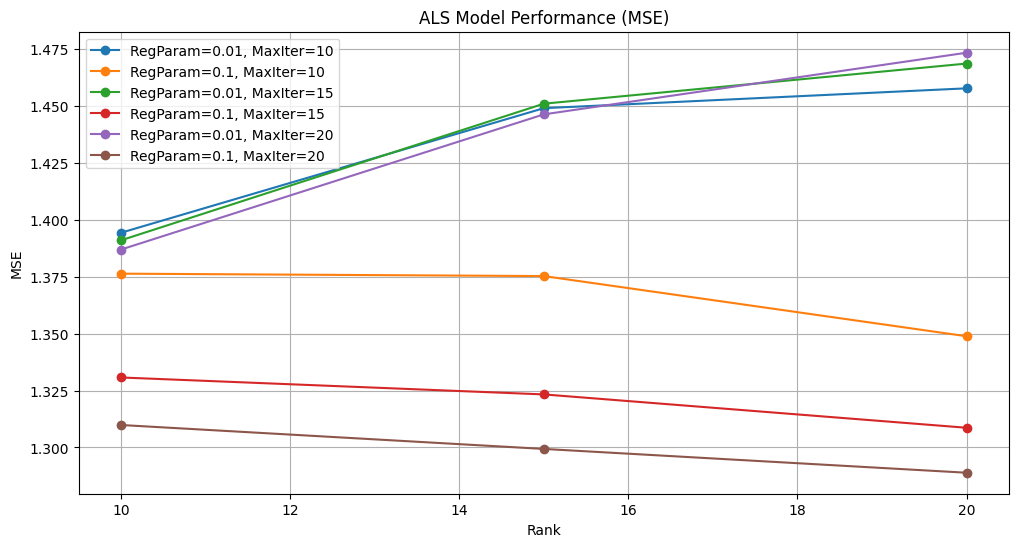

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

results = [
    [10, 10, 0.01, 1.180815350817234, 1.3943248927256275],
    [10, 10, 0.1, 1.1731780027274898, 1.3763466260836625],
    [10, 15, 0.01, 1.1794113102176378, 1.3910110386692858],
    [10, 15, 0.1, 1.1535760682452774, 1.3307377452282327],
    [10, 20, 0.01, 1.1776868490403651, 1.3869463144026235],
    [10, 20, 0.1, 1.1444896423246689, 1.3098565413884484],
    [15, 10, 0.01, 1.2037615627284417, 1.44904189990242],
    [15, 10, 0.1, 1.1727257703225304, 1.3752857323785725],
    [15, 15, 0.01, 1.2045787796232477, 1.4510100363186325],
    [15, 15, 0.1, 1.1503463327008172, 1.3232966851582189],
    [15, 20, 0.01, 1.2026316526499974, 1.446322891955664],
    [15, 20, 0.1, 1.1398884344651923, 1.299345643027507],
    [20, 10, 0.01, 1.2073785029636848, 1.4577628494188284],
    [20, 10, 0.1, 1.1614030334784975, 1.3488570061730558],
    [20, 15, 0.01, 1.2118762991737584, 1.4686441644990849],
    [20, 15, 0.1, 1.1439617842080159, 1.3086485637283871],
    [20, 20, 0.01, 1.2138407560644036, 1.473409381083003],
    [20, 20, 0.1, 1.1352944597123282, 1.288893510253507]
]


# Verileri DataFrame'e dönüştür
results_df = pd.DataFrame(results, columns=['rank', 'maxIter', 'regParam', 'rmse', 'mse'])

# Unikal maxIter değerlerini alın
max_iter_values = results_df['maxIter'].unique()

# RMSE için grafikleri çiz
plt.figure(figsize=(12, 6))
for max_iter in max_iter_values:
    for param in results_df['regParam'].unique():
        subset = results_df[(results_df['regParam'] == param) & (results_df['maxIter'] == max_iter)]
        plt.plot(subset['rank'], subset['rmse'], marker='o', label=f'RegParam={param}, MaxIter={max_iter}')
plt.title('ALS Model Performance (RMSE)')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# MSE için grafikleri çiz
plt.figure(figsize=(12, 6))
for max_iter in max_iter_values:
    for param in results_df['regParam'].unique():
        subset = results_df[(results_df['regParam'] == param) & (results_df['maxIter'] == max_iter)]
        plt.plot(subset['rank'], subset['mse'], marker='o', label=f'RegParam={param}, MaxIter={max_iter}')
plt.title('ALS Model Performance (MSE)')
plt.xlabel('Rank')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


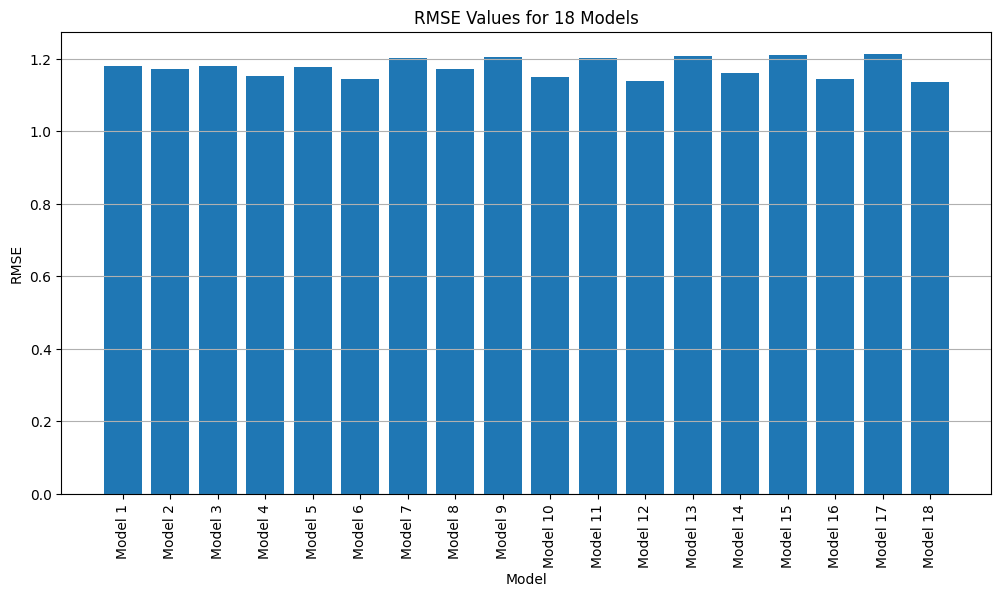

In [7]:
# Verileri DataFrame'e dönüştür
results_df = pd.DataFrame(results, columns=['rank', 'maxIter', 'regParam', 'rmse', 'mse'])

# Her modelin RMSE değerlerini çubuk grafik ile göster
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
plt.bar(x, results_df['rmse'], tick_label=[f'Model {i+1}' for i in x])
plt.title('RMSE Values for 18 Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()
